## Assessing translation quality

In this notebook, we assess the quality of the translated queries from two perspectives: semantic equivalence and vocabulary overlap.

In [ ]:
import pandas as pd
import numpy as np

## Semantic analysis

We first perform a semantic analysis on 200 query–translation pairs. For each pair, we ask Gemini whether the query and its translation are semantically equivalent. Based on Gemini's assessments, we manually inspect the pairs with problematic translations.

In [ ]:
# load the documents with the translated queries
stratified_sample = pd.read_csv('data/stratified_sample_with_translated_queries.csv')

In [ ]:
stratified_sample = stratified_sample.sample(n=200, ignore_index=True)

In [23]:
english_master_prompt = """

You are a native English speaker with a deep understanding of semantic meaning.

Task:
    Decide whether two queries express the same underlying information need for retrieving core content from the document.

Provided search queries:
    Original English query: {query}
    English query translated from Dutch: {translation}

Provided context:
    The English document: {text}

Only provide a response in the following format:
    Score: <a score on a scale from 0 to 10>

- 10 if they are semantically equivalent in this context.
- 0 if they differ significantly in intent or focus.

"""

In [24]:
dutch_master_prompt = """

You are a native Dutch speaker with a deep understanding of semantic meaning.

Task:
    Decide whether two queries express the same underlying information need for retrieving core content from the document.

Provided search queries:
    Original Dutch query: {query}
    Dutch query translated from English: {translation}

Provided context:
    The Dutch document: {text}

Only provide a response in the following format:
    Score: <a score on a scale from 0 to 10>

- 10 if they are semantically equivalent in this context.
- 0 if they differ significantly in intent or focus.

"""

In [ ]:
stratified_sample['prompt_en'] = english_master_prompt
stratified_sample['prompt_nl'] = dutch_master_prompt

In [ ]:
import time 
from google import genai
import google.generativeai as genai
import keys  # store your own key in the file keys.py

api_key = keys.GEMINI_API_KEY

if not api_key:
    raise ValueError("Gemini API key not found in keys.py.")

genai.configure(api_key=api_key)

# Select the Gemini model
model_name = "gemini-2.0-flash-lite"

model = genai.GenerativeModel(model_name)

In [ ]:
def get_raw_response(query, translation, text, prompt_template):

    prompt = prompt_template.format(query=query, translation=translation, text=text)

    try:
        response = model.generate_content(prompt,
                                          generation_config = genai.types.GenerationConfig(temperature=0.2) 
        )
        return response 
    
    except Exception as e:
        print(f"Error in get_raw_response: {e}") 
        return None

In [ ]:
# wrapper around get_raw_response function

def semantic_analysis(query, translation, text, prompt_template):

    response = get_raw_response(query, translation, text, prompt_template)  # calls the function

    if response is None:
        return "Error: No response from the API"  # handle the case where the API call failed
    
    try:
        return int(response.text.strip().split(":", 1)[1])
    except Exception as e:
        return str(e)

In [ ]:
# translate queries in both languages and put them in new columns

# empty lists to store the results
english_scores = []
dutch_scores = []

for idx, row in stratified_sample.iterrows():
    score = semantic_analysis(row['query_en'], row['translation_en'], row['text_en'], row['prompt_en'])
    english_scores.append(score)
    
    # sleep for 2 seconds to maintain max 30 requests/minute rate limit
    time.sleep(2)

for idx, row in stratified_sample.iterrows():
    score = semantic_analysis(row['query_nl'], row['translation_nl'], row['text_nl'], row['prompt_nl'])
    dutch_scores.append(score)
    
    # sleep for 2 seconds to maintain max 30 requests/minute rate limit
    time.sleep(2)

# add the results to the dataframe
stratified_sample["english_scores"] = english_scores
stratified_sample["dutch_scores"] = dutch_scores

In [ ]:
# both languages score very high, it looks like the same information need is captured by the translations

print(stratified_sample.english_scores.mean())
print(stratified_sample.dutch_scores.mean())

9.765
9.605


In [ ]:
bad_trans = stratified_sample[stratified_sample['english_scores'] == 0]

In [ ]:
# manual check of the bad translations

for row in bad_trans.values:
    print(row[7])
    print()
    print(row[11])
    print()
    print()
    print(row[8])
    print()
    print(row[12])
    print()
    print()
    print()

No action on tenders for common wheat export?

No action on tenders for soft wheat export?


Geen gevolg aan offertes voor zachte tarwe uitvoer?

Geen actie op offertes voor export van zachte tarwe?



What specific actions did the European Commission take in response to the Hellenic Republic's transitional national plan concerning industrial emissions, and what aspects of the plan did the Commission assess to determine its compliance with relevant directives and decisions?

What specific actions did the European Commission take in response to the Dutch search query?


Welke specifieke acties heeft de Europese Commissie ondernomen naar aanleiding van het nationale plan voor de overgangsfase van de Helleense Republiek betreffende industriële emissies, en welke aspecten van het plan heeft de Commissie beoordeeld om de naleving ervan met de relevante richtlijnen en besluiten vast te stellen?

Welke specifieke acties heeft de Europese Commissie ondernomen naar aanleiding van de Engelse zoe

## Vocabulary analysis

In addition to semantic evaluation, we analyze how closely the translations match the source queries in terms of vocabulary. For this purpose we use metrics such as length ratio, type token ratio, Levenshtein distance and Jaccard similarity.

In [ ]:
# load the documents with the translated queries again, to analyse the vocabulary consistency

stratified_sample = pd.read_csv('data/stratified_sample_with_translated_queries.csv')

In [ ]:
# same preprocessing function as used before applying BM25
# so the resulting scores will more accurately reflect the “vocabulary overlap” as BM25 understands it.

import string
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

def preprocess_columns(column):
    # Lowercase and remove punctuation using vectorized string methods
    clean_series = column.str.lower().str.translate(str.maketrans('', '', string.punctuation))
    # Tokenize using nltk's word_tokenize
    return clean_series.apply(word_tokenize)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/corfrederickx/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# length ratio for English

stratified_sample["len_orig_en"] = preprocess_columns(stratified_sample["query_en"]).str.len()
stratified_sample["len_trans_en"] = preprocess_columns(stratified_sample["translation_en"]).str.len()
stratified_sample["len_ratio_en"] = stratified_sample["len_trans_en"] / stratified_sample["len_orig_en"]

In [ ]:
# length ratio for Dutch

stratified_sample["len_orig_nl"] = preprocess_columns(stratified_sample["query_nl"]).str.len()
stratified_sample["len_trans_nl"] = preprocess_columns(stratified_sample["translation_nl"]).str.len()
stratified_sample["len_ratio_nl"] = stratified_sample["len_trans_nl"] / stratified_sample["len_orig_nl"]

In [ ]:
print(stratified_sample.len_ratio_en.mean())
print(stratified_sample.len_ratio_nl.mean())

print(stratified_sample.len_ratio_en.median())
print(stratified_sample.len_ratio_nl.median())

0.9942130154072082
1.0327988458229809
1.0
1.0


In [ ]:
# Type Token Ratio

def ttr(text):
    tokens = word_tokenize(text.lower().translate(str.maketrans('', '', string.punctuation)))
    return len(set(tokens)) / len(tokens) if tokens else 0

stratified_sample["ttr_orig_en"] = stratified_sample["query_en"].apply(ttr)
stratified_sample["ttr_trans_en"] = stratified_sample["translation_en"].apply(ttr)

print('English comparison')
print('mean:')
print(stratified_sample["ttr_orig_en"].mean())
print(stratified_sample["ttr_trans_en"].mean())
print()
print('median:')
print(stratified_sample["ttr_orig_en"].median())
print(stratified_sample["ttr_trans_en"].median())

stratified_sample["ttr_orig_nl"] = stratified_sample["query_nl"].apply(ttr)
stratified_sample["ttr_trans_nl"] = stratified_sample["translation_nl"].apply(ttr)

print()
print('Dutch comparison')
print('mean:')
print(stratified_sample["ttr_orig_nl"].mean())
print(stratified_sample["ttr_trans_nl"].mean())
print()
print('median:')
print(stratified_sample["ttr_orig_nl"].median())
print(stratified_sample["ttr_trans_nl"].median())

English comparison
mean:
0.8464257077669312
0.8425547957542449

median:
0.850531914893617
0.8461538461538461

Dutch comparison
mean:
0.8390118706027597
0.8471200103180401

median:
0.8333333333333334
0.8461538461538461


In [ ]:
!pip install Levenshtein

In [ ]:
# Levenshtein distance, gives a sense of the rewriting effort that is done. Measured on the character level so no tokenization required

import Levenshtein as lev

def norm_lev(a, b):
    return lev.distance(a, b) / max(len(a), len(b))

stratified_sample["lev_dist_norm_en"] = stratified_sample.apply(lambda r: norm_lev(r.query_en, r.translation_en), axis=1)
stratified_sample["lev_dist_norm_nl"] = stratified_sample.apply(lambda r: norm_lev(r.query_nl, r.translation_nl), axis=1)

print('mean:')
print(f'English: {stratified_sample.lev_dist_norm_en.mean()}')
print(f'Dutch: {stratified_sample.lev_dist_norm_nl.mean()}')
print()
print('median:')
print(f'English: {stratified_sample.lev_dist_norm_en.median()}')
print(f'Dutch: {stratified_sample.lev_dist_norm_nl.median()}')


mean:
English: 0.17914668681648183
Dutch: 0.2935508862302427

median:
English: 0.08385695956837846
Dutch: 0.25525785769881965


In [ ]:
# Jaccard similarity. Measures the proportion of shared types in the union of both queries (original and translated). How much lexical overlap is there?

def jaccard(a, b):
    ta, tb = set(word_tokenize(a.lower().translate(str.maketrans('', '', string.punctuation)))), set(word_tokenize(b.lower().translate(str.maketrans('', '', string.punctuation))))
    if not ta and not tb:
        return 1.0  # both empty
    return len(ta & tb) / len(ta | tb)

stratified_sample["jaccard_en"] = stratified_sample.apply(lambda r: jaccard(r.query_en, r.translation_en), axis=1)
stratified_sample["jaccard_nl"] = stratified_sample.apply(lambda r: jaccard(r.query_nl, r.translation_nl), axis=1)

print('mean:')
print(f'English: {stratified_sample.jaccard_en.mean()}')
print(f'Dutch: {stratified_sample.jaccard_nl.mean()}')
print()
print('median:')
print(f'English: {stratified_sample.jaccard_en.median()}')
print(f'Dutch: {stratified_sample.jaccard_nl.median()}')

mean:
English: 0.7816351460738077
Dutch: 0.6069158171652285

median:
English: 0.8588039867109634
Dutch: 0.6363636363636364


In [ ]:
# on average about 60 percent of the unique tokens in an orginial Dutch query and its translation overlap.
# whether this will impact BM25 depends on what kind of words the 39 percent of non-overlapping words belong to. 
# If they are key content words (rare, high IDF words), BM25 will suffer, while it is robust to a few missing stopwords

In [ ]:
# Jaccard similarity after removing stopwords

import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

stop_en = set(stopwords.words('english'))
stop_nl = set(stopwords.words('dutch'))

# tokenizer that also drops stopwords
def tokenize(text, lang):
    cleaned = text.lower().translate(str.maketrans('', '', string.punctuation))
    tokens  = word_tokenize(cleaned)
    stops   = stop_en if lang == 'en' else stop_nl
    return [t for t in tokens if t not in stops]

def jaccard(a, b, lang):
    ta, tb = set(tokenize(a, lang)), set(tokenize(b, lang))
    if not ta and not tb:
        return 1.0
    return len(ta & tb) / len(ta | tb)

# 4) apply to your DataFrame
stratified_sample["jaccard_en_nostop"] = stratified_sample.apply(
    lambda r: jaccard(r.query_en,       r.translation_en, 'en'), axis=1
)
stratified_sample["jaccard_nl_nostop"] = stratified_sample.apply(
    lambda r: jaccard(r.query_nl,       r.translation_nl, 'nl'), axis=1
)

print('mean:')
print('English (no stopwords):',   stratified_sample.jaccard_en_nostop.mean())
print('Dutch  (no stopwords):',    stratified_sample.jaccard_nl_nostop.mean())
print()
print('median:')
print('English (no stopwords):', stratified_sample.jaccard_en_nostop.median())
print('Dutch  (no stopwords):',  stratified_sample.jaccard_nl_nostop.median())


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/corfrederickx/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/corfrederickx/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


mean:
English (no stopwords): 0.767845400306925
Dutch  (no stopwords): 0.5676272566487954

median:
English (no stopwords): 0.8591269841269842
Dutch  (no stopwords): 0.5841194968553459


In [ ]:
# scores go down in both languages, but in Dutch, dropping stopwords has a much larger effect.
# For English, most of your Jaccard overlap comes from content words—not just from shared “the”, “of”, etc. Even after removing stops, queries still share about 77 % of their content tokens on average.

# For Dutch, a larger chunk of the previous overlap was just stopwords. 
# Once you strip those out, the average content‐word overlap drops: only 57 % of unique Dutch content tokens appear to coincide between original and translation.
# and content tokens are essential for BM25, this explains the significant drop. 

In [ ]:
# We try Jaccard another time, but this time compare the jaccard similarity between document-originial query and document-translated query

def jaccard(a, b):
    ta, tb = set(word_tokenize(a.lower().translate(str.maketrans('', '', string.punctuation)))), set(word_tokenize(b.lower().translate(str.maketrans('', '', string.punctuation))))
    if not ta and not tb:
        return 1.0  # both empty
    return len(ta & tb) / len(ta | tb)

stratified_sample["jaccard_en_doc_original"] = stratified_sample.apply(lambda r: jaccard(r.text_en, r.query_en), axis=1)
stratified_sample["jaccard_nl_doc_original"] = stratified_sample.apply(lambda r: jaccard(r.text_nl, r.query_nl), axis=1)

stratified_sample["jaccard_en_doc_translation"] = stratified_sample.apply(lambda r: jaccard(r.text_en, r.translation_en), axis=1)
stratified_sample["jaccard_nl_doc_translation"] = stratified_sample.apply(lambda r: jaccard(r.text_nl, r.translation_nl), axis=1)

print('English similarity with original query:')
print(f'English mean: {stratified_sample.jaccard_en_doc_original.mean()}')
print(f'English median: {stratified_sample.jaccard_en_doc_original.median()}')
print()
print('English similarity with translated query:')
print(f'English mean: {stratified_sample.jaccard_en_doc_translation.mean()}')
print(f'English median: {stratified_sample.jaccard_en_doc_translation.median()}')
print()
print()
print('Dutch similarity with original query:')
print(f'Dutch mean: {stratified_sample.jaccard_nl_doc_original.mean()}')
print(f'Dutch median: {stratified_sample.jaccard_nl_doc_original.median()}')
print()
print('Dutch similarity with translated query:')
print(f'Dutch mean: {stratified_sample.jaccard_nl_doc_translation.mean()}')
print(f'Dutch median: {stratified_sample.jaccard_nl_doc_translation.median()}')


English similarity with original query:
English mean: 0.10260915217643148
English median: 0.09791615009504917

English similarity with translated query:
English mean: 0.09708001416581169
English median: 0.09397805977780876


Dutch similarity with original query:
Dutch mean: 0.10182732952414085
Dutch median: 0.09451682176091625

Dutch similarity with translated query:
Dutch mean: 0.08549936408294008
Dutch median: 0.08070254786672698


In [ ]:
# and without stopwords

import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

stop_en = set(stopwords.words('english'))
stop_nl = set(stopwords.words('dutch'))

# tokenizer that also drops stopwords
def tokenize(text, lang):
    cleaned = text.lower().translate(str.maketrans('', '', string.punctuation))
    tokens  = word_tokenize(cleaned)
    stops   = stop_en if lang == 'en' else stop_nl
    return [t for t in tokens if t not in stops]

def jaccard(a, b, lang):
    ta, tb = set(tokenize(a, lang)), set(tokenize(b, lang))
    if not ta and not tb:
        return 1.0
    return len(ta & tb) / len(ta | tb)

stratified_sample["jaccard_en_doc_original"] = stratified_sample.apply(lambda r: jaccard(r.text_en, r.query_en, 'en'), axis=1)
stratified_sample["jaccard_nl_doc_original"] = stratified_sample.apply(lambda r: jaccard(r.text_nl, r.query_nl, 'nl'), axis=1)

stratified_sample["jaccard_en_doc_translation"] = stratified_sample.apply(lambda r: jaccard(r.text_en, r.translation_en, 'en'), axis=1)
stratified_sample["jaccard_nl_doc_translation"] = stratified_sample.apply(lambda r: jaccard(r.text_nl, r.translation_nl, 'nl'), axis=1)

print('English similarity with original query:')
print(f'English mean: {stratified_sample.jaccard_en_doc_original.mean()}')
print(f'English median: {stratified_sample.jaccard_en_doc_original.median()}')
print()
print('English similarity with translated query:')
print(f'English mean: {stratified_sample.jaccard_en_doc_translation.mean()}')
print(f'English median: {stratified_sample.jaccard_en_doc_translation.median()}')
print()
print()
print('Dutch similarity with original query:')
print(f'Dutch mean: {stratified_sample.jaccard_nl_doc_original.mean()}')
print(f'Dutch median: {stratified_sample.jaccard_nl_doc_original.median()}')
print()
print('Dutch similarity with translated query:')
print(f'Dutch mean: {stratified_sample.jaccard_nl_doc_translation.mean()}')
print(f'Dutch median: {stratified_sample.jaccard_nl_doc_translation.median()}')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/corfrederickx/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/corfrederickx/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


English similarity with original query:
English mean: 0.07978904748757899
English median: 0.06976744186046512

English similarity with translated query:
English mean: 0.07374993369404555
English median: 0.06487493987493986


Dutch similarity with original query:
Dutch mean: 0.06963871523354807
Dutch median: 0.058394160583941604

Dutch similarity with translated query:
Dutch mean: 0.05238363717897916
Dutch median: 0.044642857142857144


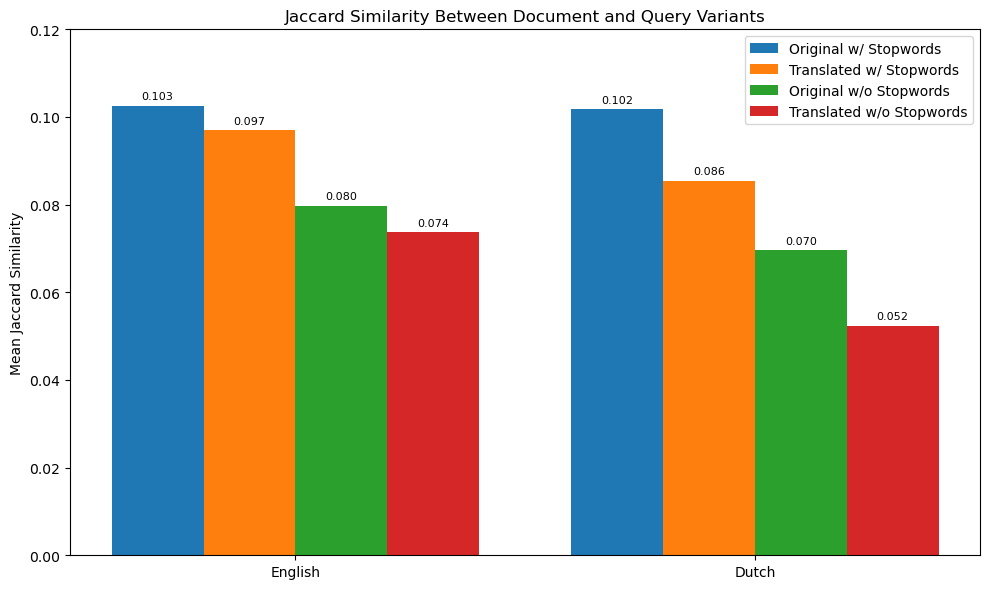

In [ ]:
# potential visualisation of last two tests

import matplotlib.pyplot as plt
import numpy as np

# Mean similarity values (from your data)
mean_original_with_sw = [0.1026, 0.1018]
mean_translated_with_sw = [0.0971, 0.0855]
mean_original_no_sw = [0.0798, 0.0696]
mean_translated_no_sw = [0.0737, 0.0524]

# Languages
languages = ['English', 'Dutch']
x = np.arange(len(languages))  # the label locations
width = 0.2  # width of the bars

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for each group
bars1 = ax.bar(x - 1.5 * width, mean_original_with_sw, width, label='Original w/ Stopwords')
bars2 = ax.bar(x - 0.5 * width, mean_translated_with_sw, width, label='Translated w/ Stopwords')
bars3 = ax.bar(x + 0.5 * width, mean_original_no_sw, width, label='Original w/o Stopwords')
bars4 = ax.bar(x + 1.5 * width, mean_translated_no_sw, width, label='Translated w/o Stopwords')

# Add labels and formatting
ax.set_ylabel('Mean Jaccard Similarity')
ax.set_title('Jaccard Similarity Between Document and Query Variants')
ax.set_xticks(x)
ax.set_xticklabels(languages)
ax.set_ylim(0, 0.12)
ax.legend()

# Function to annotate bar values
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

# Annotate all bars
for bar_group in [bars1, bars2, bars3, bars4]:
    annotate_bars(bar_group)

# Layout adjustment
plt.tight_layout()
plt.show()
